In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)
library(here)

devtools::load_all(".")

plan(multiprocess, workers = 30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /mnt/expressions/mp/archaic-ychr


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: future


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘lemon’


The following object is masked from ‘package:purrr’:

    %||%


The following objects are masked from ‘package:ggplot

## Function definitions

In [2]:
bin_values <- function(x, n_bins) {
    boundaries <- seq(0, 1, length.out = n_bins)
    cut(x, quantile(x, boundaries), include.lowest = T)
}

In [3]:
# Read tables with simulated trajectories.
read_trajectories <- function(model, human_Ne, neand_Ne, admix_rates, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", human_Ne), function(Ne1) {
    map_dfr(sprintf("%d", neand_Ne), function(Ne2) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {

        f <- here(glue("data/sim/{model}/humanNe{Ne1}_neandNe{Ne2}_rate{admix_rate}_rep{rep}_traj.tsv"))

        read_tsv(f, col_types = "id") %>%
            mutate(human_Ne = as.integer(Ne1),
                   neand_Ne = as.integer(Ne2),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep,
                   time = gen * 25)

    })
    })
    })
    })
}

In [4]:
# Read population output files and calculate fitness values of each
# simulated Y chromosome.
read_fitness <- function(model, human_Ne, neand_Ne, admix_rates, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", human_Ne), function(Ne1) {
    map_dfr(sprintf("%d", neand_Ne), function(Ne2) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {

        f <- here(glue("data/sim/{model}/humanNe{Ne1}_neandNe{Ne2}_rate{admix_rate}_rep{rep}_pop.txt.gz"))

        read_slim(f) %>%
            calculate_fitness %>%
            mutate(human_Ne = as.integer(Ne1),
                   neand_Ne = as.integer(Ne2),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep)

    })
    })
    })
    }) %>%
    mutate(pop = case_when(pop == "p1" ~ "AMH", pop == "p2" ~ "Neanderthals"))
}

## Visualize the ratios of $N_e$ values across a grid

In [5]:
grid_df <- expand_grid(
    neand_Ne = seq(200, 2000, 200),
    human_Ne = seq(5000, 15000, 1000),
) %>%
    mutate(
        ratio = neand_Ne / human_Ne,
        logratio = log10(ratio),
        bin = bin_values(ratio, 11)
    )

head(grid_df)

neand_Ne human_Ne ratio      logratio  bin            
1 200       5000    0.04000000 -1.397940 (0.0305,0.05]  
2 200       6000    0.03333333 -1.477121 (0.0305,0.05]  
3 200       7000    0.02857143 -1.544068 [0.0133,0.0305]
4 200       8000    0.02500000 -1.602060 [0.0133,0.0305]
5 200       9000    0.02222222 -1.653213 [0.0133,0.0305]
6 200      10000    0.02000000 -1.698970 [0.0133,0.0305]

In [6]:
table(grid_df$bin)


[0.0133,0.0305]   (0.0305,0.05]     (0.05,0.07]   (0.07,0.0901]   (0.0901,0.11] 
             11              12              10              11              11 
    (0.11,0.13]    (0.13,0.151]    (0.151,0.18]    (0.18,0.234]     (0.234,0.4] 
             11              11              11              11              11 

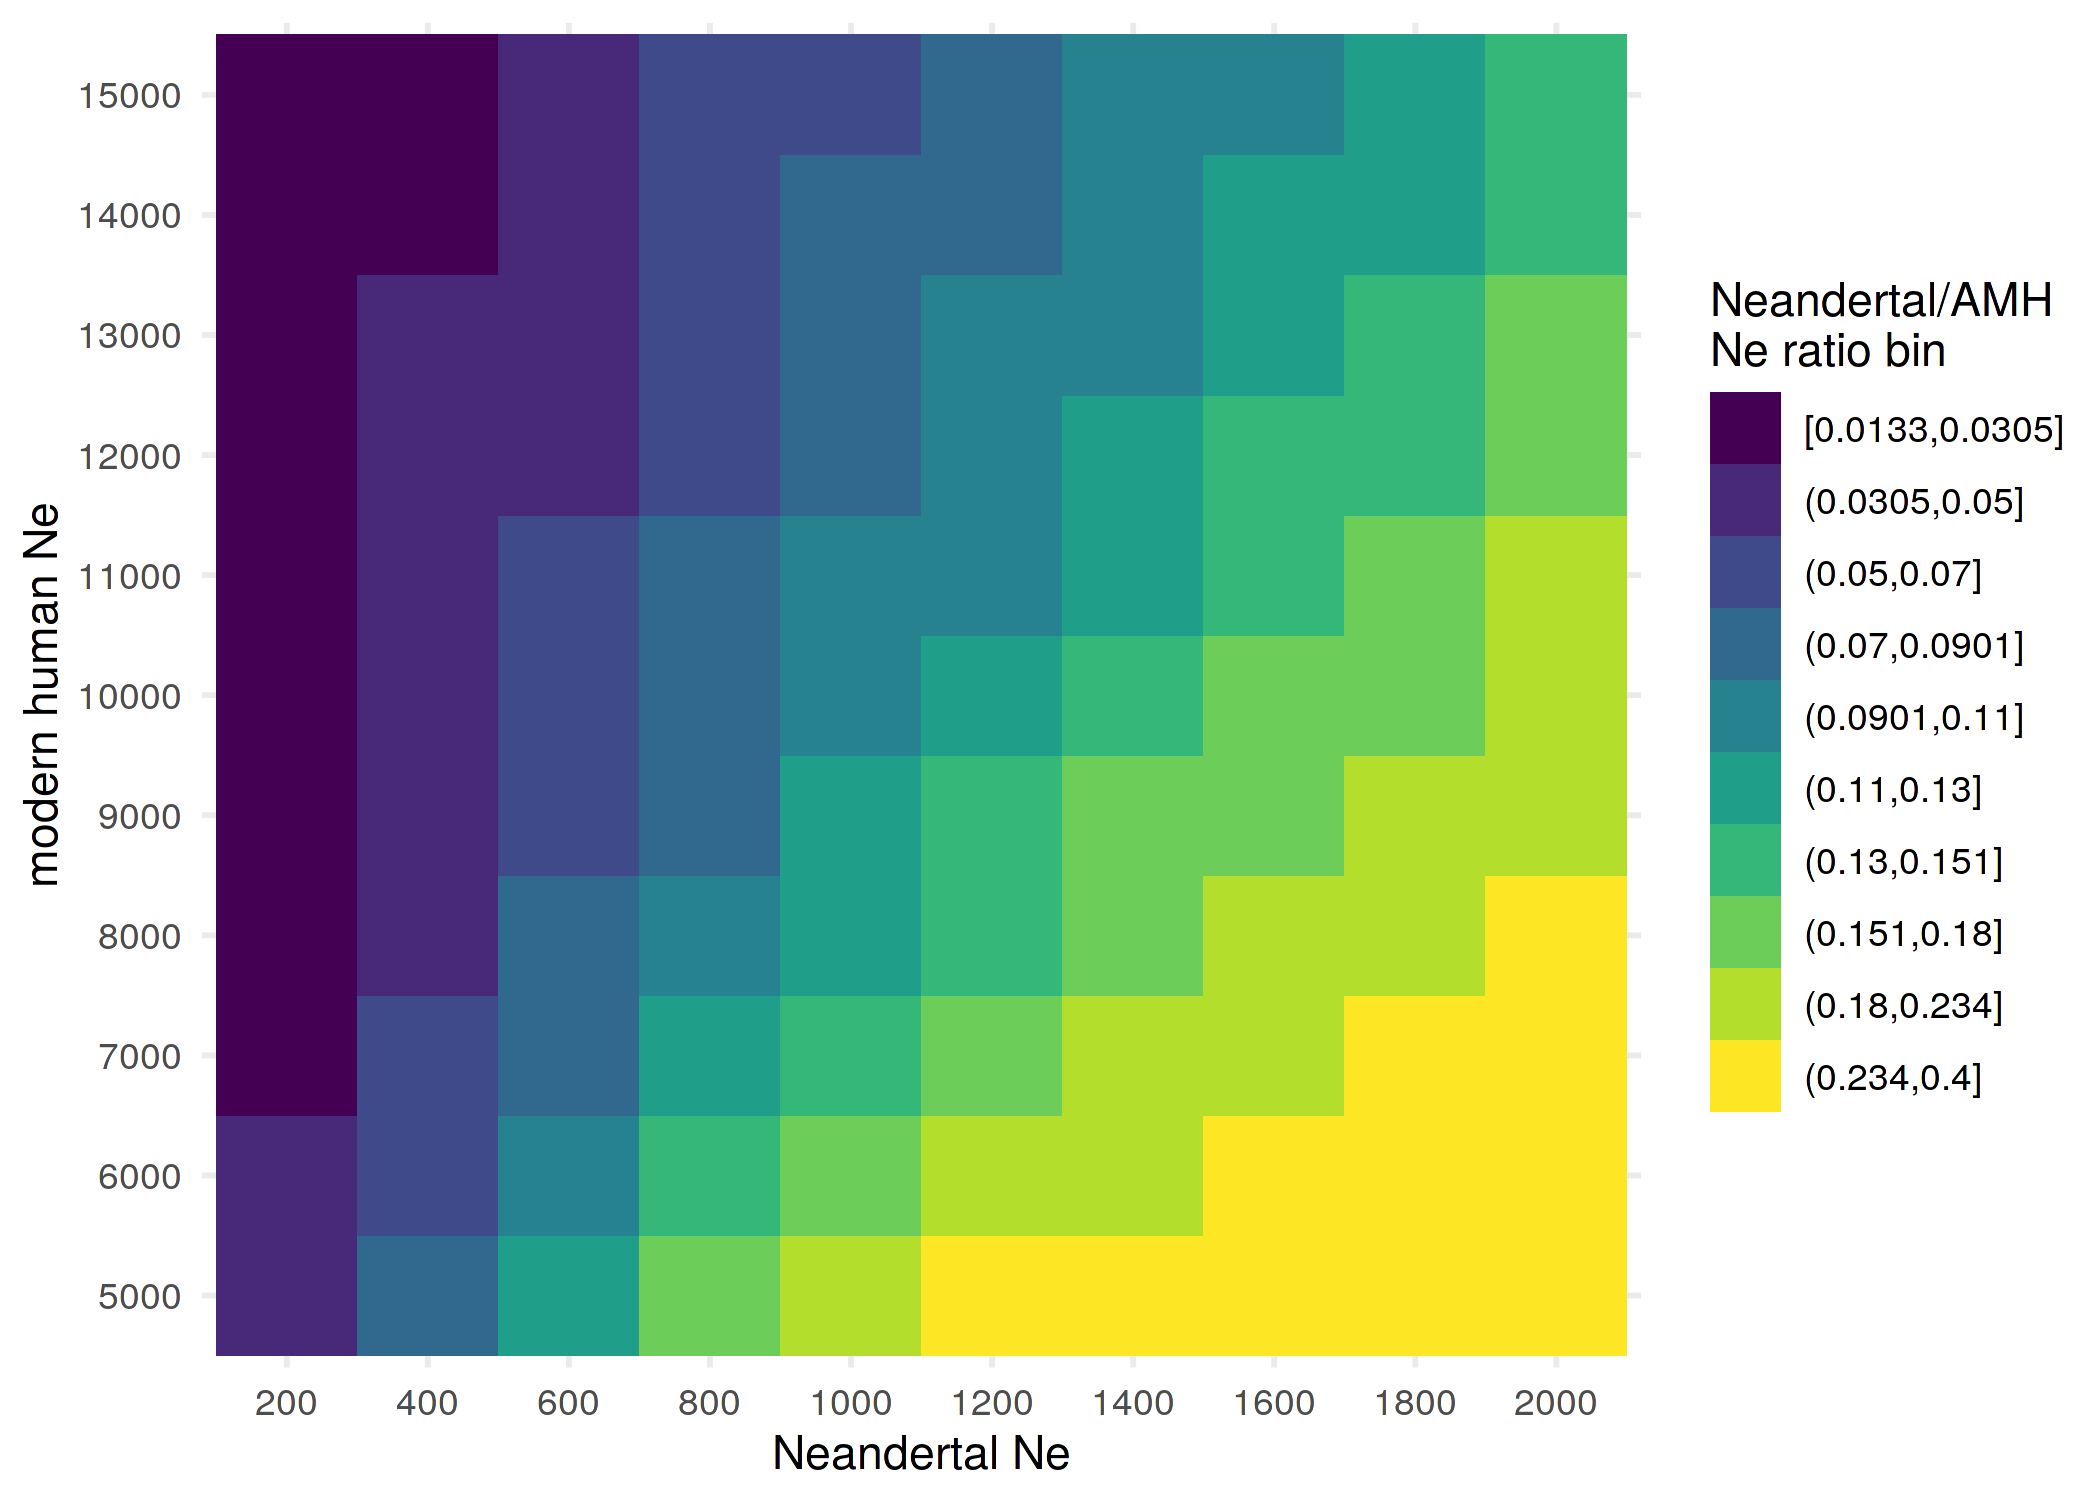

In [7]:
set_dim(7, 5)

ggplot(grid_df, aes(factor(neand_Ne), factor(human_Ne))) +
    geom_tile(aes(fill = bin)) +
    scale_fill_viridis_d() +
    theme_minimal() +
    guides(fill = guide_legend(title = "Neandertal/AMH\nNe ratio bin")) +
    labs(y = "modern human Ne", x = "Neandertal Ne")

## Load trajectories simulated across a grid of population sizes and admixture rates

In [8]:
traj <- read_trajectories(
    model = "demography",
    human_Ne = seq(5000, 15000, 1000),
    neand_Ne = seq(200, 2000, 200),
    admix_rates = seq(0.01, 0.1, 0.01),
    reps = 1:30
) %>%
    mutate(a_rate = paste0("admixture = ", admix_rate))

In [9]:
neutraj <- read_trajectories(
    model = "neutral",
    human_Ne = seq(5000, 15000, 1000),
    neand_Ne = seq(200, 2000, 200),
    admix_rates = seq(0.01, 0.1, 0.01),
    reps = 1:30
) %>%
    mutate(a_rate = paste0("admixture = ", admix_rate))

## Calculate averages over replicates

Frequencies of introgressed AMH Y chromosomes:

In [10]:
mean_bin_traj <- traj %>%
    mutate(Ne_ratio = neand_Ne / human_Ne,
          Ne_bin = bin_values(Ne_ratio, 11)) %>%
    group_by(gen, time, Ne_bin, admix_rate, a_rate) %>%
    summarise(ancestry = mean(ancestry))

In [11]:
mean_bin_neutraj <- neutraj %>%
    mutate(Ne_ratio = neand_Ne / human_Ne,
          Ne_bin = bin_values(Ne_ratio, 11)) %>%
    group_by(gen, time, Ne_bin, admix_rate, a_rate) %>%
    summarise(ancestry = mean(ancestry))

Probabilities of fixation of introgressed AMH Y chromosomes:

In [12]:
prob_bin_traj <- traj %>%
    mutate(Ne_ratio = neand_Ne / human_Ne,
          Ne_bin = bin_values(Ne_ratio, 11)) %>%
    group_by(gen, time, Ne_bin, admix_rate, a_rate) %>%
    summarise(ancestry = mean(ancestry == 1))

In [13]:
prob_bin_neutraj <- neutraj %>%
    mutate(Ne_ratio = neand_Ne / human_Ne,
          Ne_bin = bin_values(Ne_ratio, 11)) %>%
    group_by(gen, time, Ne_bin, admix_rate, a_rate) %>%
    summarise(ancestry = mean(ancestry == 1))

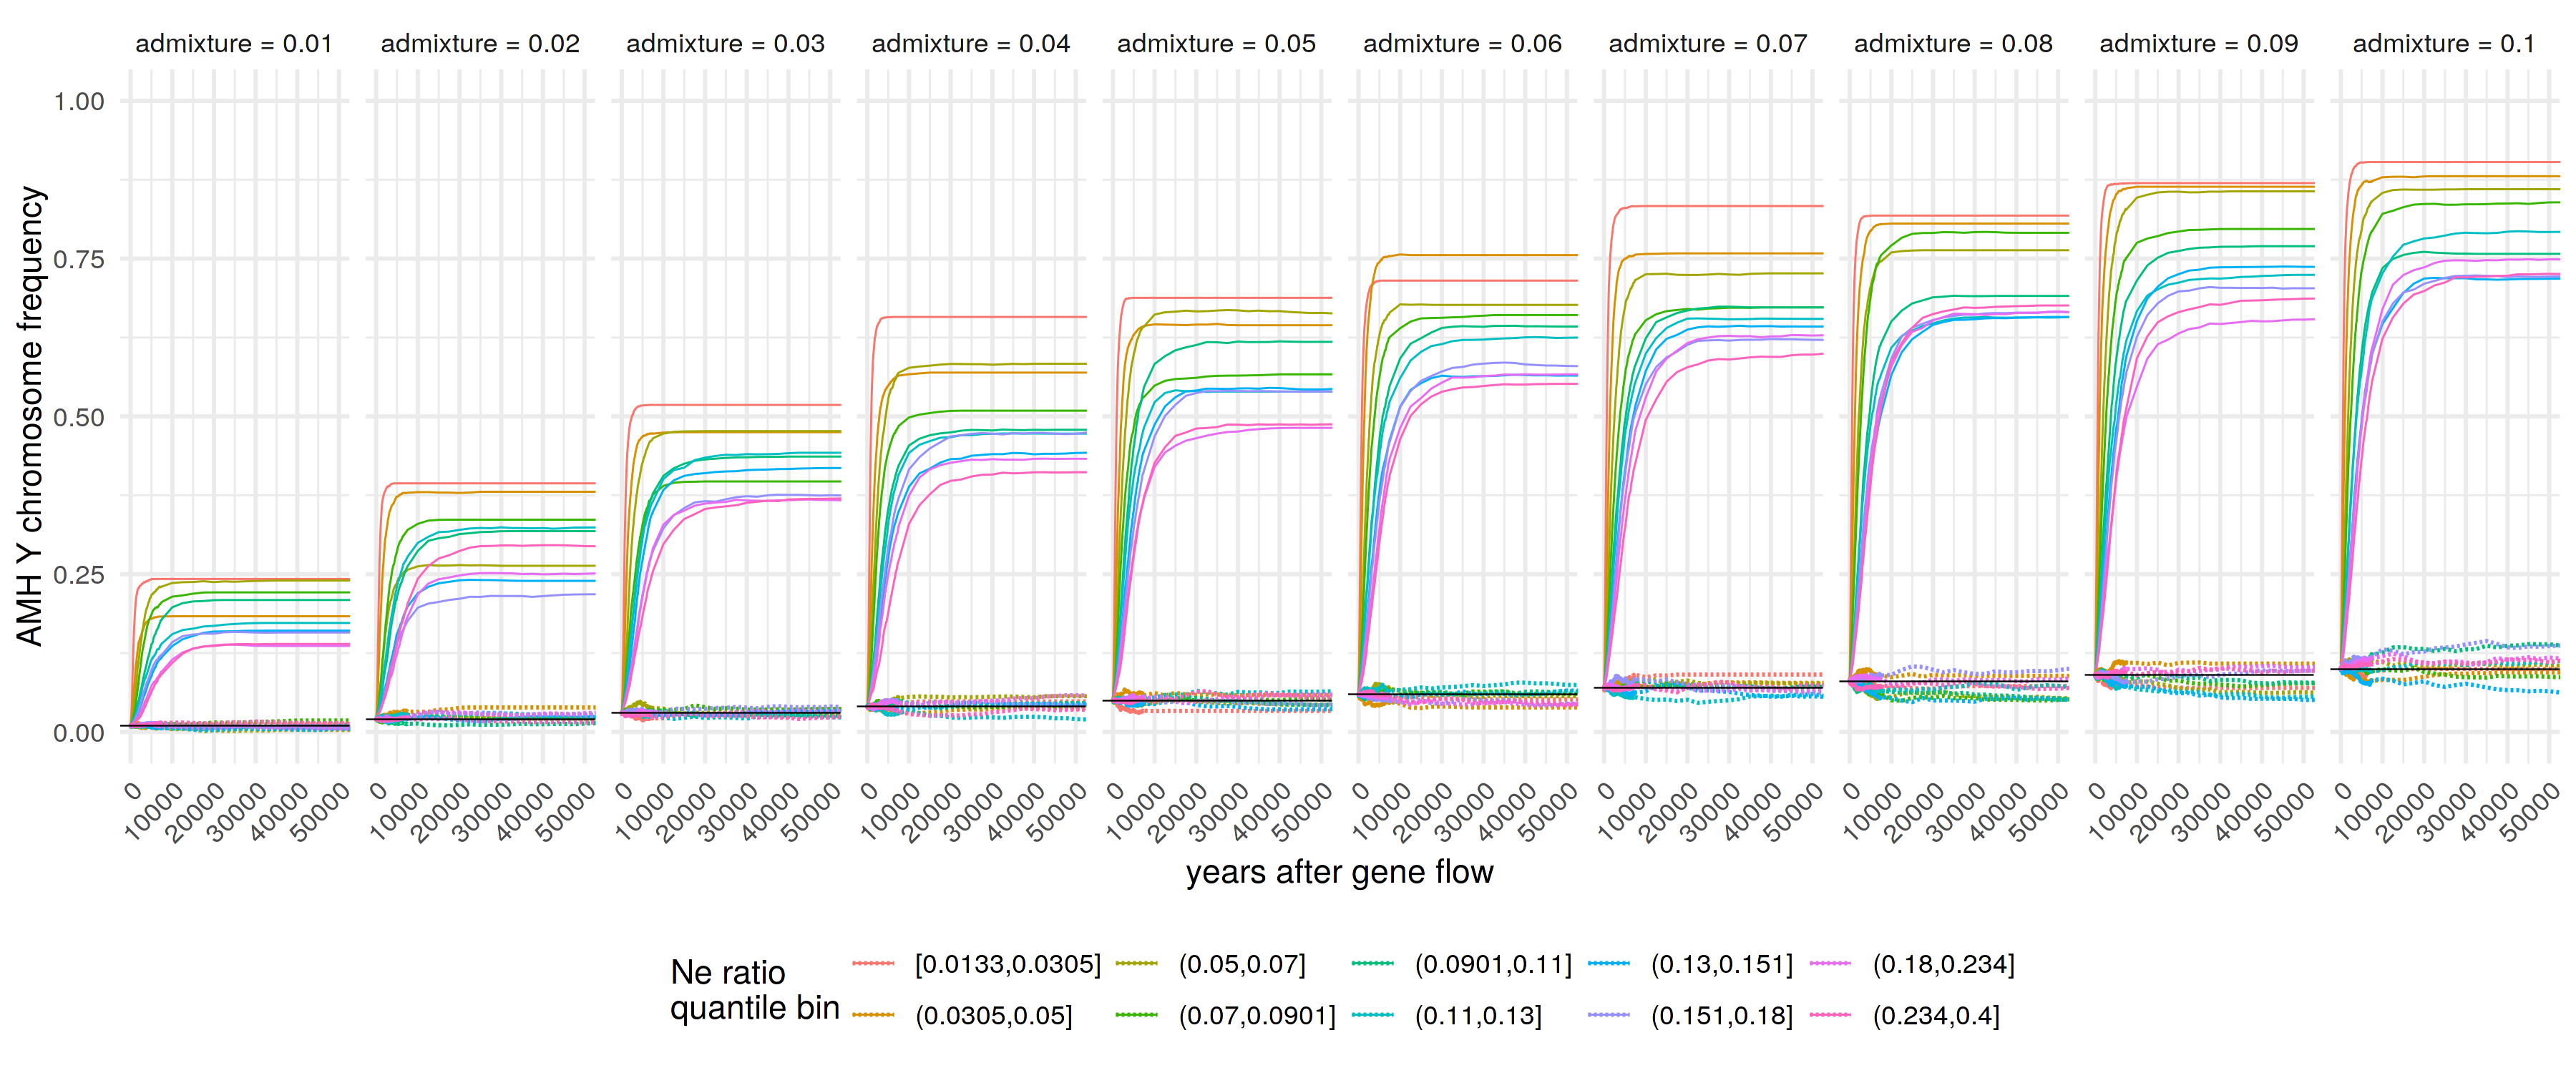

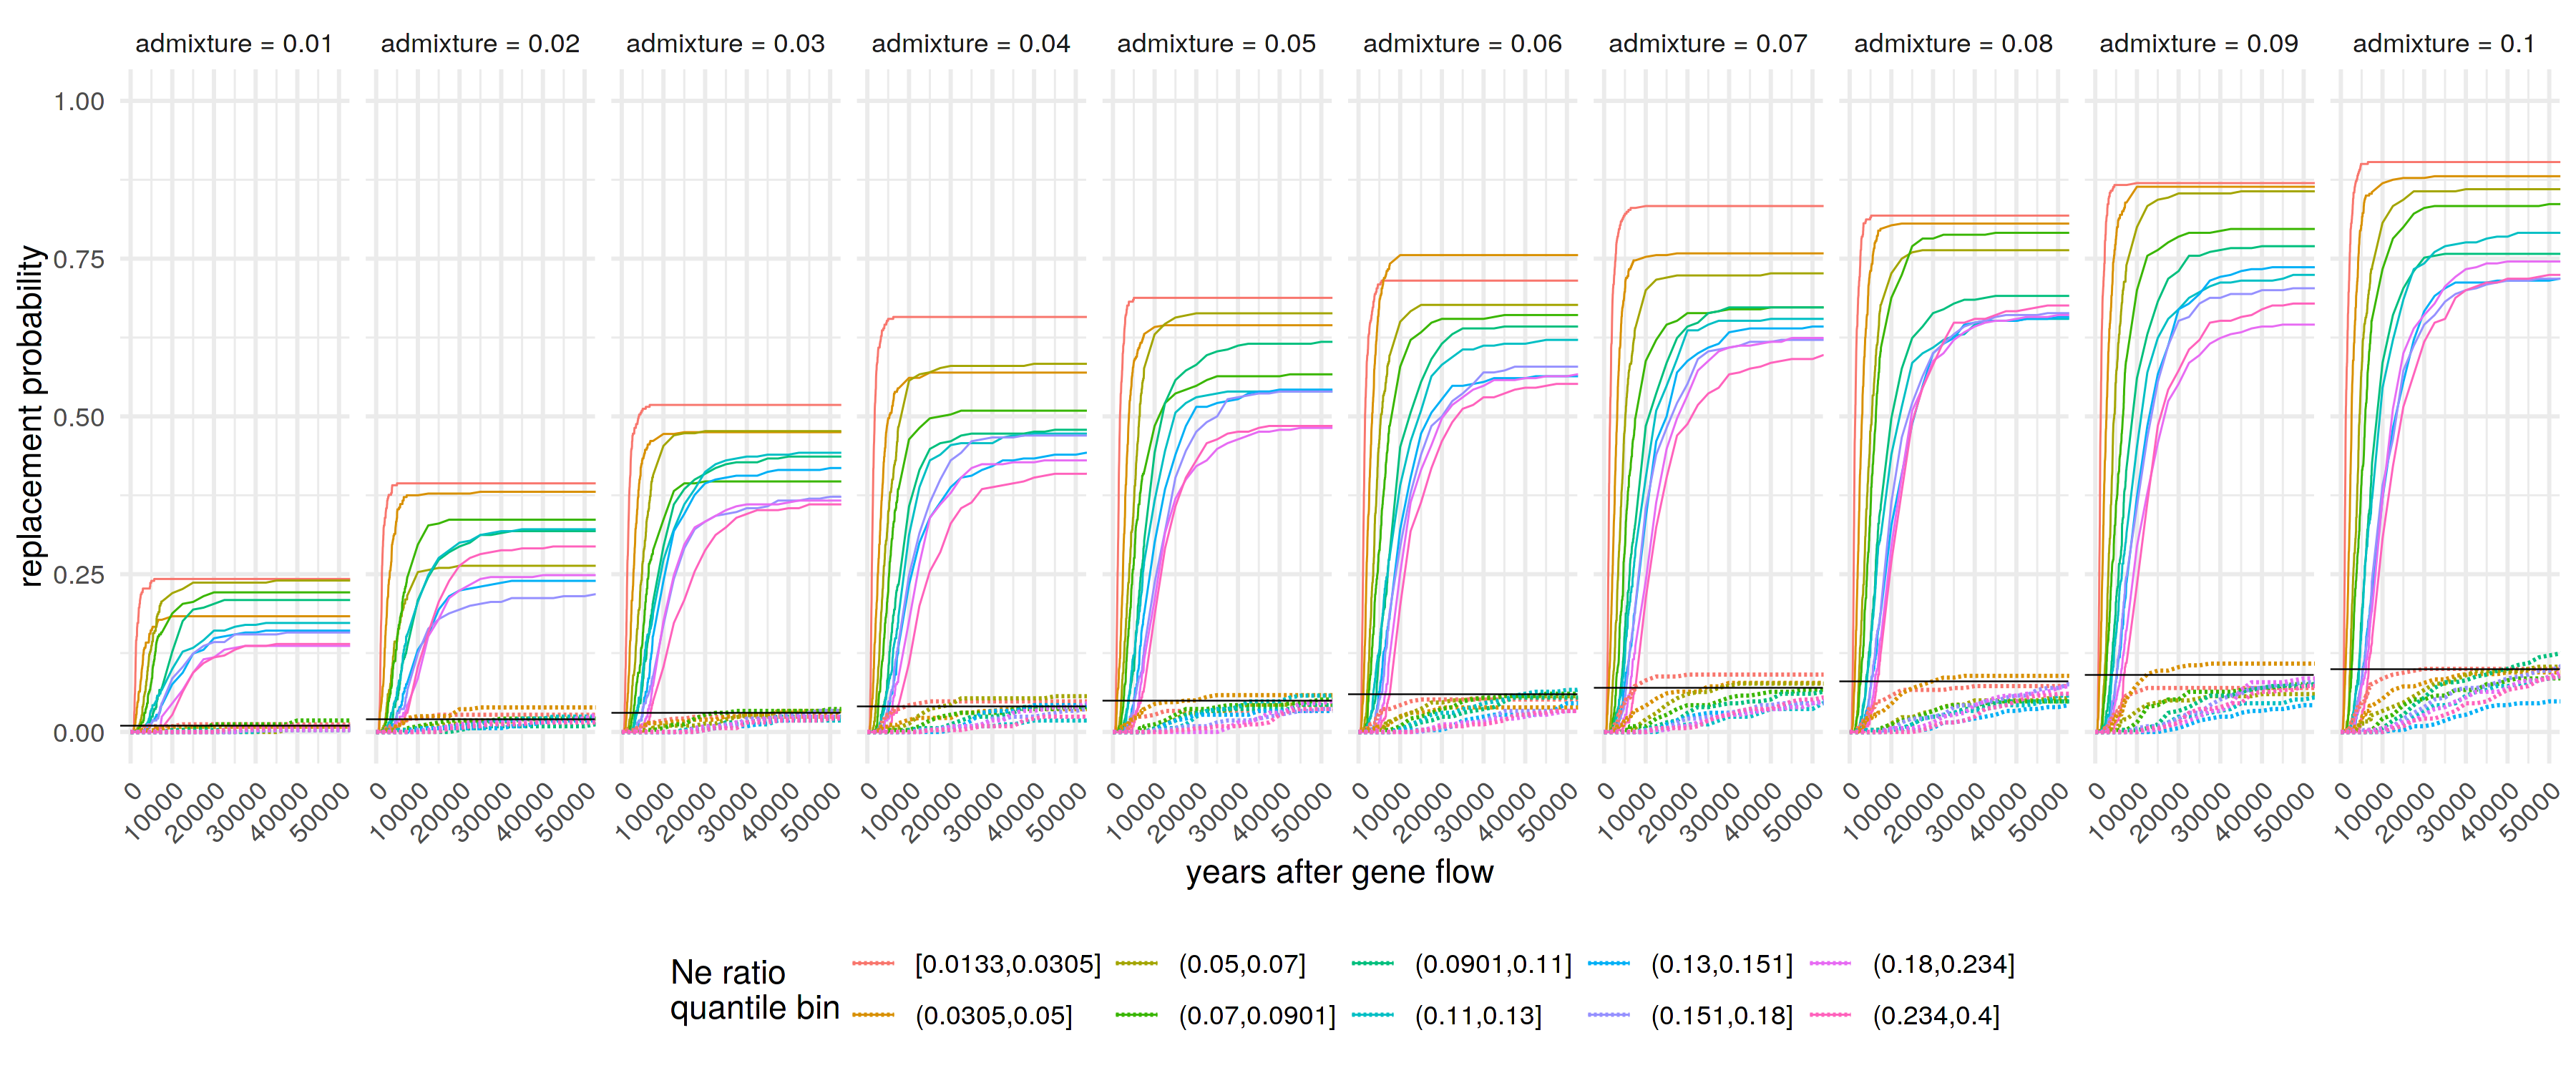

In [14]:
set_dim(12, 5)

# frequency trajectories between 0-20k years after introgression
ggplot(mean_bin_traj, aes(time, ancestry, color = Ne_bin)) +
    geom_line(size = 0.25) +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_wrap(~ a_rate, nrow = 1) +
    theme_minimal() +
    theme(legend.position = "bottom",
          axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(y = c(0, 1), xlim = c(0, 50000)) +
    guides(color = guide_legend(title = "Ne ratio\nquantile bin")) +
    geom_line(data = mean_bin_neutraj, linetype = 2) +
    geom_hline(aes(yintercept = admix_rate), size = 0.2)

# fixation probability trajectories between 0-20k years after introgression
ggplot(prob_bin_traj, aes(time, ancestry, color = Ne_bin)) +
    geom_line(size = 0.25) +
    xlab("years after gene flow") + ylab("replacement probability") +
    facet_wrap(~ a_rate, nrow = 1) +
    theme_minimal() +
    theme(legend.position = "bottom",
          axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(y = c(0, 1), xlim = c(0, 50000)) +
    guides(color = guide_legend(title = "Ne ratio\nquantile bin")) +
    geom_line(data = prob_bin_neutraj, linetype = 2, size = 0.5) +
    geom_hline(aes(yintercept = admix_rate), size = 0.2)

Just the neutral probabilities:

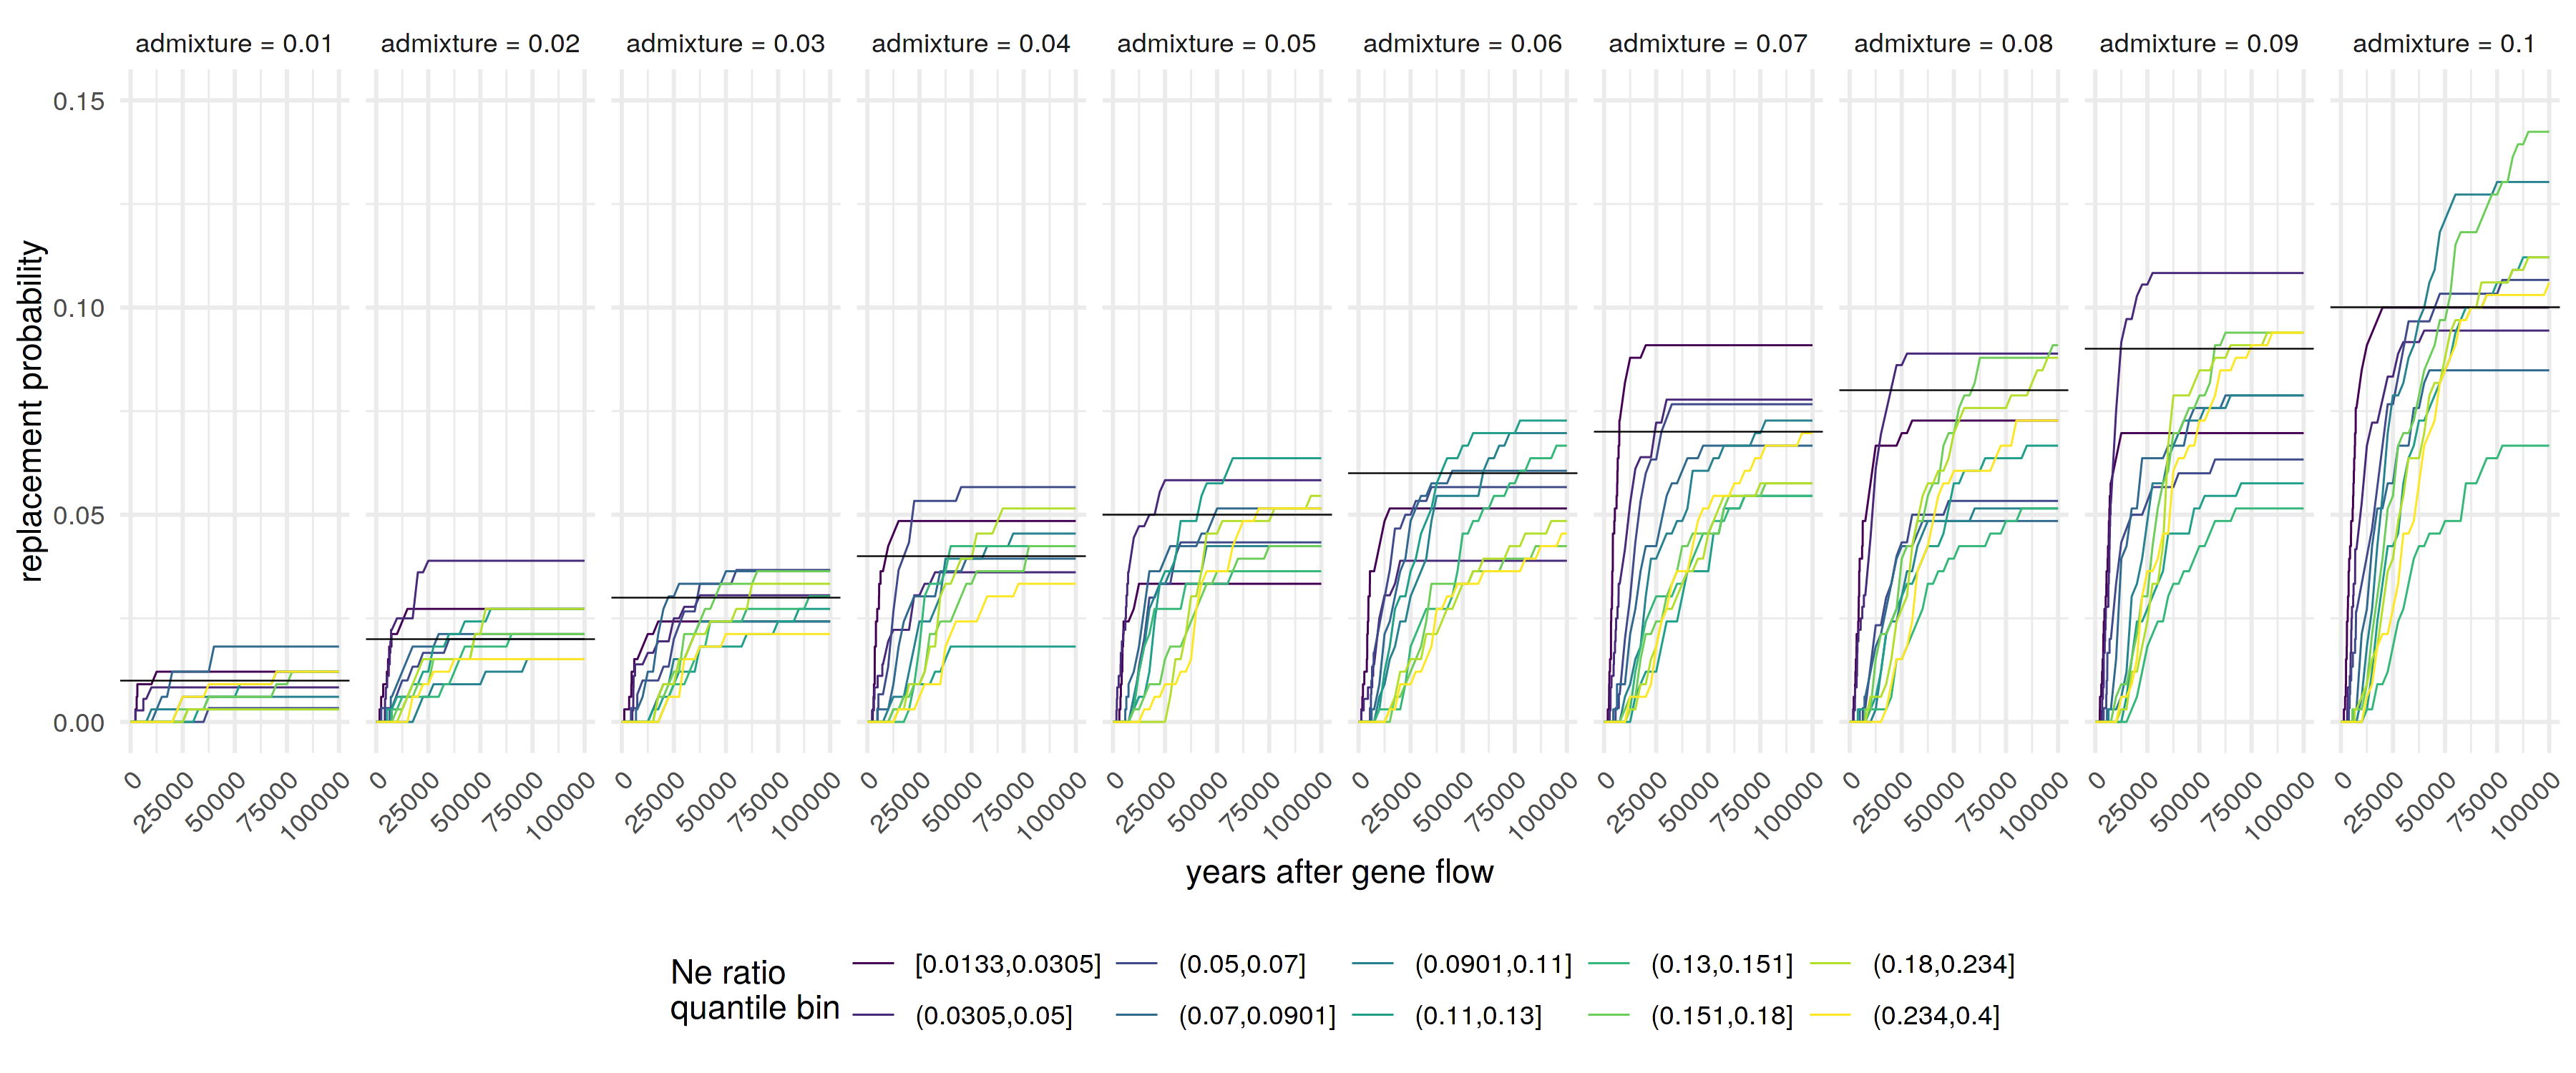

In [15]:
set_dim(12, 5)

ggplot(prob_bin_neutraj, aes(time, ancestry, color = Ne_bin)) +
    geom_line(size = 0.25) +
    xlab("years after gene flow") + ylab("replacement probability") +
    facet_grid(.~ a_rate) +
    theme_minimal() +
    theme(legend.position = "bottom",
          axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(y = c(0, 0.15)) +
    guides(color = guide_legend(title = "Ne ratio\nquantile bin")) +
    geom_hline(aes(yintercept = admix_rate), size = 0.2) +
    scale_color_viridis_d()

## Assign fitness values to trajectories

In [16]:
suppressWarnings({ # just because of a recent cosmetic change in the tibble API which causes warnings
fitness <- read_fitness(
    model = "demography",
    human_Ne = seq(5000, 15000, 1000),
    neand_Ne = seq(200, 2000, 200),
    admix_rates = seq(0.01, 0.1, 0.01),
    reps = 1:30
)
})

In [17]:
head(fitness)

genome_id pop S           fitness   human_Ne neand_Ne admix_rate rep
1 p1:10001  AMH 0.006655564 0.9933665 5000     200      0.01       1  
2 p1:10003  AMH 0.004996003 0.9950165 5000     200      0.01       1  
3 p1:10005  AMH 0.096148816 0.9083288 5000     200      0.01       1  
4 p1:10007  AMH 0.010865935 0.9891929 5000     200      0.01       1  
5 p1:10009  AMH 0.014550433 0.9855549 5000     200      0.01       1  
6 p1:10011  AMH 0.005363943 0.9946504 5000     200      0.01       1

Annotate each replicate trajectory with the value of Neanderthal and AMH loads prior to the gene flow event (averageing per-population fitness values across genomes in each `group_by`):

In [18]:
traj_fitness <- fitness %>%
    group_by(pop, rep, human_Ne, neand_Ne, admix_rate) %>%
    summarise(fitness = mean(fitness)) %>%
    spread(pop, fitness) %>%
    mutate(fitness_ratio = 1 - Neanderthals / AMH) %>%
    mutate(Ne_ratio = neand_Ne / human_Ne) %>%
    inner_join(traj) %>% mutate(time = gen * 25)

Joining, by = c("rep", "human_Ne", "neand_Ne", "admix_rate")



In [19]:
head(traj_fitness)

rep human_Ne neand_Ne admix_rate AMH       Neanderthals fitness_ratio
1 1   5000     200      0.01       0.9899623 0.8477356    0.1436688    
2 1   5000     200      0.01       0.9899623 0.8477356    0.1436688    
3 1   5000     200      0.01       0.9899623 0.8477356    0.1436688    
4 1   5000     200      0.01       0.9899623 0.8477356    0.1436688    
5 1   5000     200      0.01       0.9899623 0.8477356    0.1436688    
6 1   5000     200      0.01       0.9899623 0.8477356    0.1436688    
  Ne_ratio gen ancestry time a_rate          
1 0.04     0   0.02       0  admixture = 0.01
2 0.04     1   0.04      25  admixture = 0.01
3 0.04     2   0.02      50  admixture = 0.01
4 0.04     3   0.04      75  admixture = 0.01
5 0.04     4   0.01     100  admixture = 0.01
6 0.04     5   0.03     125  admixture = 0.01

#### This section up until the probability calculation is actually not needed

I used it to double check that I'm still getting the same trajectories (also potentially stratified by fitness bin) as in the first figures at the beginning of this notebook.

Assign trajectories to bins based on the relative Neand/AMH fitness (averaging over replicates) and also in bins of _Ne_ ratios:

In [20]:
mean_traj_fitness <- traj_fitness %>%
    group_by(gen, time, human_Ne, neand_Ne, admix_rate) %>%
    summarise(ancestry = mean(ancestry),
              fitness_ratio = mean(fitness_ratio),
              Ne_ratio = mean(Ne_ratio))

In [21]:
min(mean_traj_fitness$fitness_ratio)

[1] 0.005947193

In [22]:
max(mean_traj_fitness$fitness_ratio)

[1] 0.1407596

In [23]:
(boundaries <- c(0.0, seq(0.005, 0.15, 0.01)))

[1] 0.000 0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105
[13] 0.115 0.125 0.135 0.145

In [24]:
mean_traj_fitness <- mean_traj_fitness %>% mutate(fitness_bin = cut(fitness_ratio, boundaries))

In [25]:
mean_traj_fitness$fitness_bin %>% table

.
    (0,0.005] (0.005,0.015] (0.015,0.025] (0.025,0.035] (0.035,0.045] 
            0        134186         89570         37180         36504 
(0.045,0.055] (0.055,0.065] (0.065,0.075] (0.075,0.085] (0.085,0.095] 
          338         32110          4732             0             0 
(0.095,0.105] (0.105,0.115] (0.115,0.125] (0.125,0.135] (0.135,0.145] 
            0             0          9126         22308          5746 

Divide trajectories in ten quantile bins based on $N_e$-ratio:

In [26]:
mean_traj_fitness$Ne_bin <- bin_values(mean_traj_fitness$Ne_ratio, 11)

In [27]:
mean_traj_fitness$Ne_bin %>% table

.
[0.0133,0.0305]   (0.0305,0.05]     (0.05,0.07]   (0.07,0.0901]   (0.0901,0.11] 
          37180           40560           33800           37180           37180 
    (0.11,0.13]    (0.13,0.151]    (0.151,0.18]    (0.18,0.234]     (0.234,0.4] 
          37180           37180           37180           37180           37180 

### Calculate probabilities of fixation in each time point

In [28]:
prob_traj_fitness <- traj_fitness %>%
    group_by(gen, time, human_Ne, neand_Ne, admix_rate) %>%
    summarise(prob_fix = mean(ancestry == 1),
              fitness_ratio = mean(fitness_ratio),
              Ne_ratio = mean(Ne_ratio))

In [29]:
prob_traj_fitness %>% head

gen time human_Ne neand_Ne admix_rate prob_fix fitness_ratio Ne_ratio
1 0   0    5000     200      0.01       0        0.1284698     0.04    
2 0   0    5000     200      0.02       0        0.1292604     0.04    
3 0   0    5000     200      0.03       0        0.1158988     0.04    
4 0   0    5000     200      0.04       0        0.1228169     0.04    
5 0   0    5000     200      0.05       0        0.1389424     0.04    
6 0   0    5000     200      0.06       0        0.1230075     0.04

Bin the probability trajectories based on fitness differences and $N_e$-ratios again:

In [30]:
prob_traj_fitness$fitness_bin <- cut(prob_traj_fitness$fitness_ratio, boundaries)

In [31]:
prob_traj_fitness$Ne_bin <- bin_values(prob_traj_fitness$Ne_ratio, 11)

In [32]:
prob_traj_fitness %>%
filter(admix_rate == 0.05, gen == 0) %>% 
.$fitness_bin %>% table

.
    (0,0.005] (0.005,0.015] (0.015,0.025] (0.025,0.035] (0.035,0.045] 
            0            41            25            11            11 
(0.045,0.055] (0.055,0.065] (0.065,0.075] (0.075,0.085] (0.085,0.095] 
            0            11             0             0             0 
(0.095,0.105] (0.105,0.115] (0.115,0.125] (0.125,0.135] (0.135,0.145] 
            0             0             2             7             2 

## Decompose probabilities back on the 2D parameter grid

In [33]:
set_dim(16, 8)

prob_heatmap <- function(df, t) {
    df %>%
        filter(time == t) %>%
        ungroup %>%
        mutate(admix_rate = glue("admix. rate = {admix_rate}")) %>%
        mutate(prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))) %>% {
        ggplot(data = ., aes(factor(neand_Ne), factor(human_Ne))) +
            geom_tile(aes(fill = prob_fix)) +
            scale_fill_viridis_c(limits = c(0, 1)) +
            guides(
                fill = guide_legend(title = "replacement\nprobability")
            ) +
            labs(y = "MH Ne", x = "Neandertal Ne") +
            theme_minimal() +
            theme(text = element_text(size = 15), axis.text.x = element_text(angle = 90, vjust = 0.5),
                  legend.position = "right") +
            facet_wrap(~ factor(admix_rate), nrow = 1)
        }
}

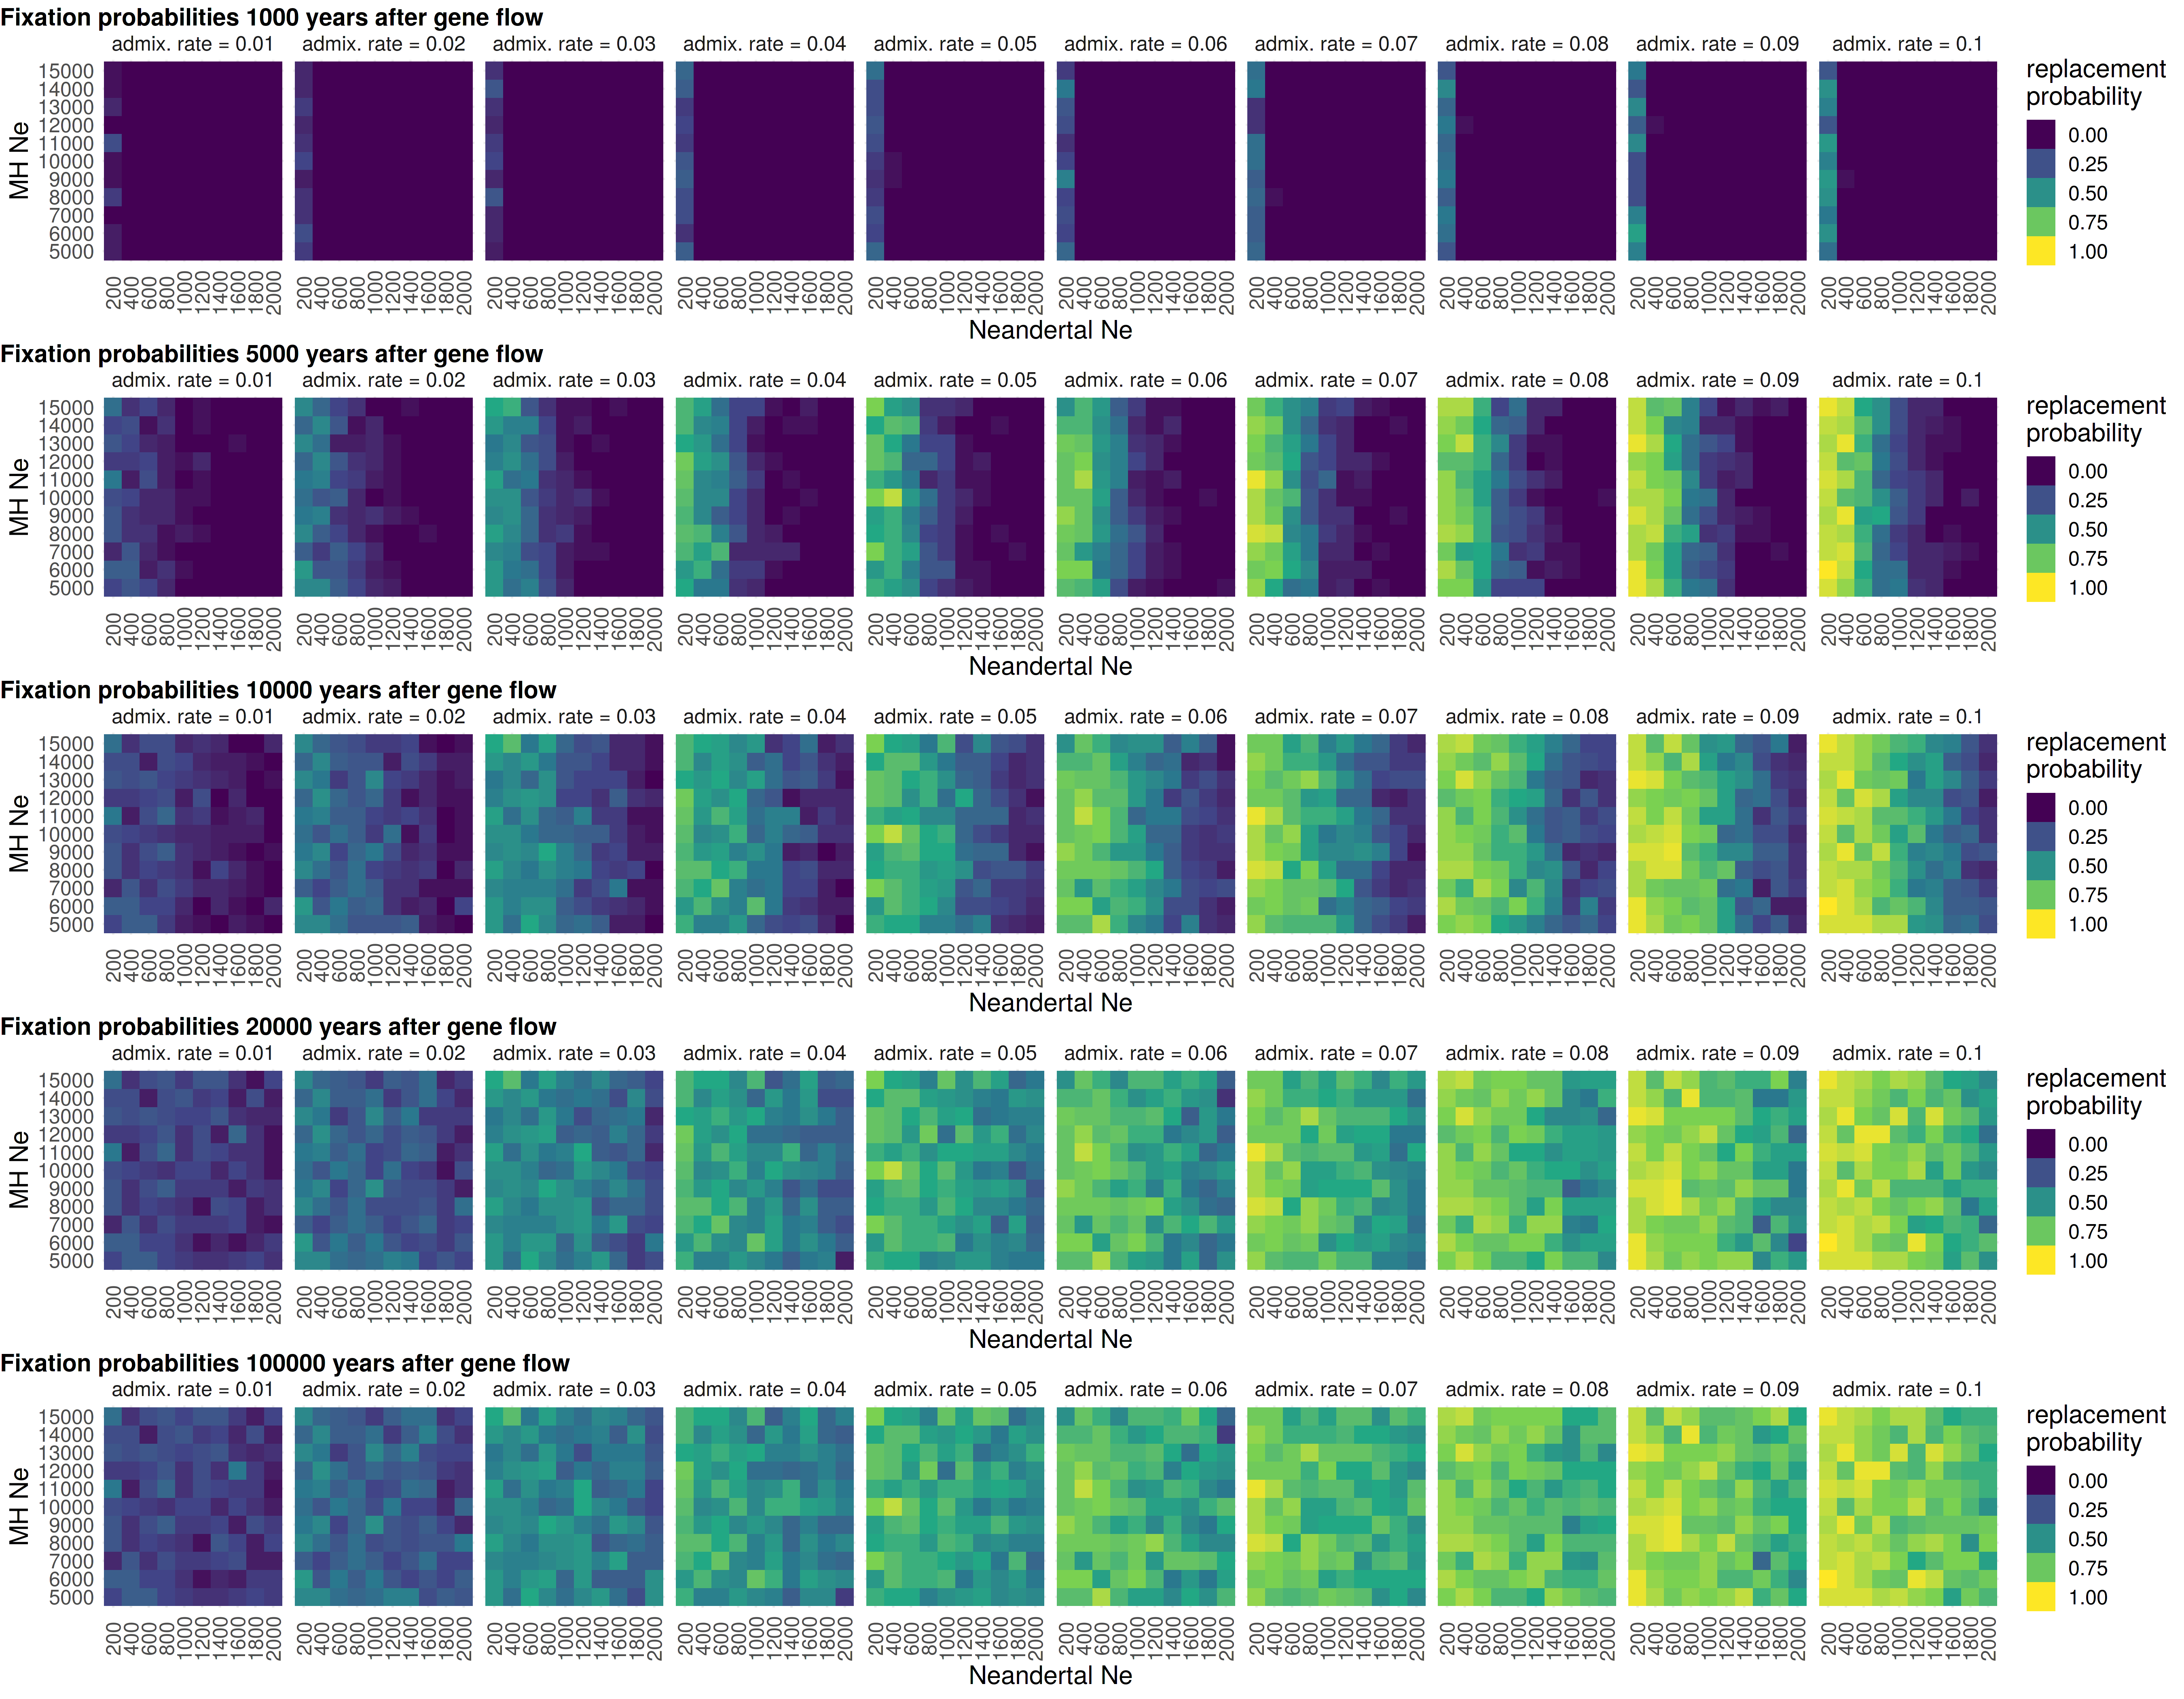

In [34]:
set_dim(18, 14)

plot_grid(
    NULL,
    prob_heatmap(prob_traj_fitness, 1000),
    prob_heatmap(prob_traj_fitness, 5000),
    prob_heatmap(prob_traj_fitness, 10000),
    prob_heatmap(prob_traj_fitness, 20000),
    prob_heatmap(prob_traj_fitness, 100000),
    labels = c("", sprintf("Fixation probabilities %d years after gene flow",
                     c(1000, 5000, 10000, 20000, 100000))),
    hjust = "left", vjust = 0.5,
    ncol = 1,
    rel_heights = c(0.05, rep(1, 5))
)   

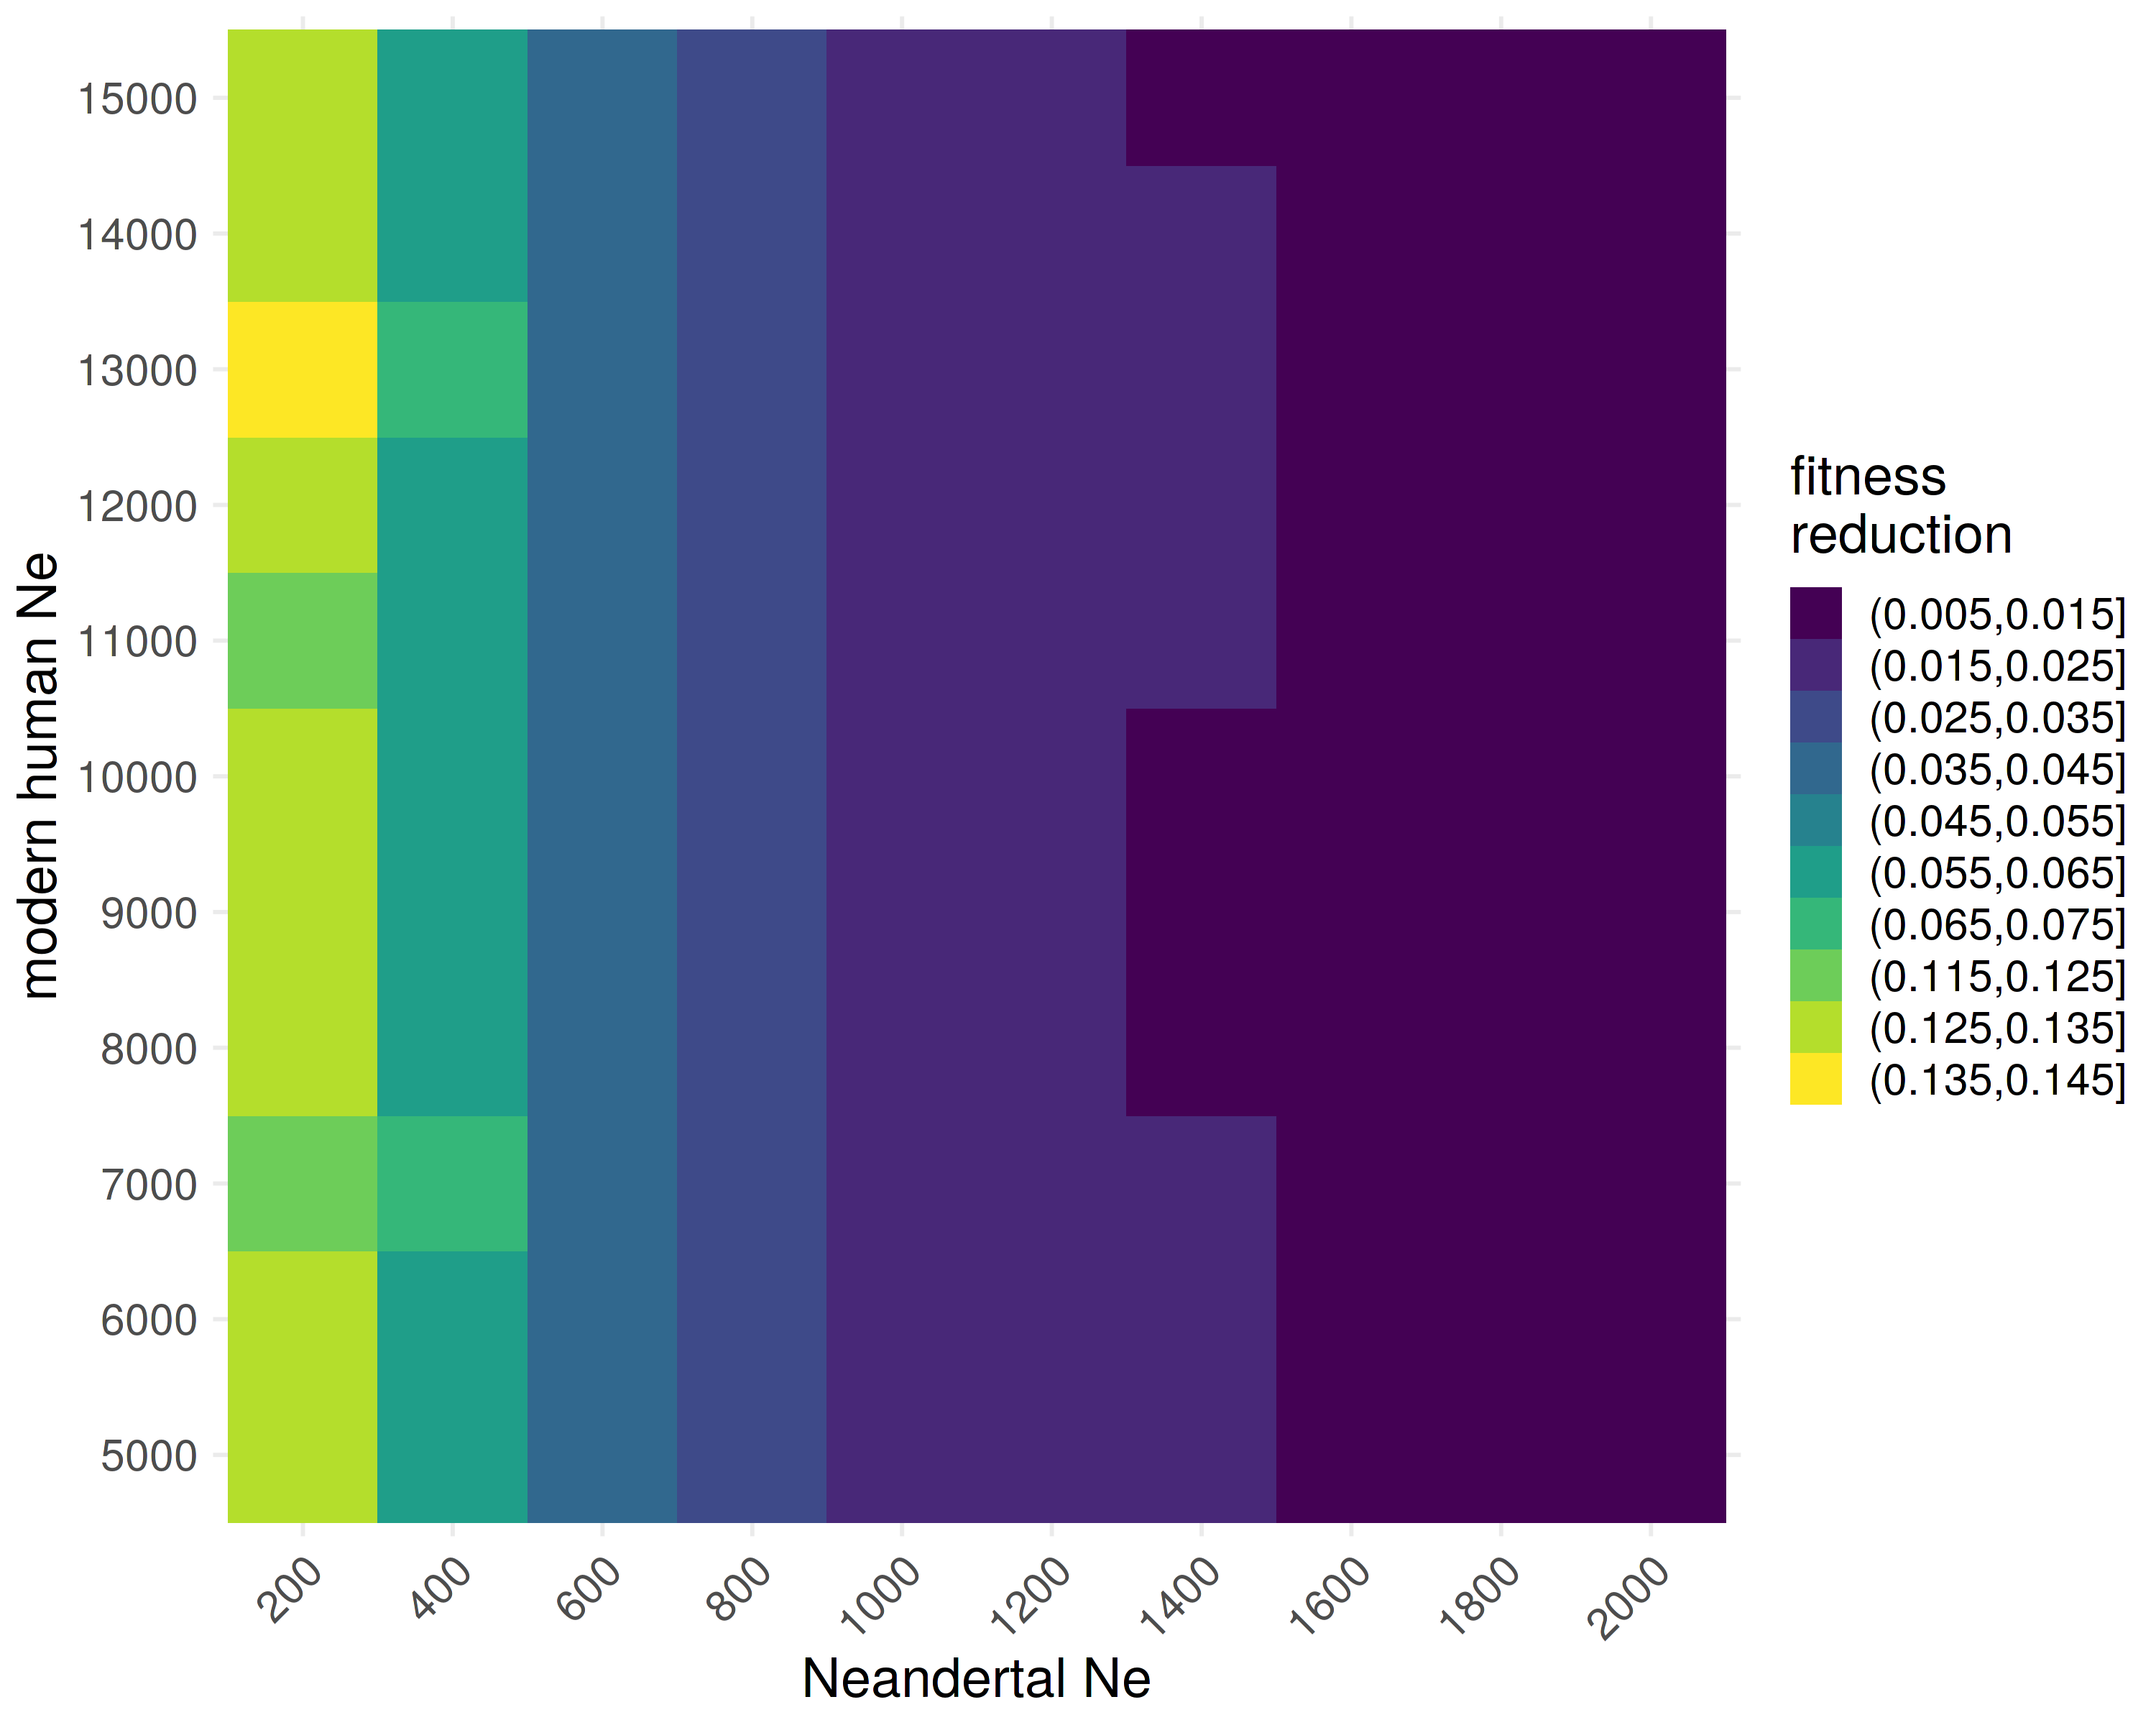

In [35]:
set_dim(10, 8)

prob_traj_fitness %>%
filter(time == 20000) %>%
ungroup %>%
mutate(prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))) %>% {
ggplot(data = ., aes(factor(neand_Ne), factor(human_Ne))) +
    geom_tile(aes(fill = fitness_bin)) +
    scale_fill_viridis_d() +
    guides(
        fill = guide_legend(title = "fitness\nreduction")
    ) +
    labs(y = "modern human Ne", x = "Neandertal Ne") +
    theme_minimal() +
    theme(text = element_text(size = 18), axis.text.x = element_text(angle = 45, hjust = 1))
}

Replace missing probabilities with 0 and black color:

In [57]:
set_dim(16, 8)

prob_heatmap <- function(df, t) {
    df %>%
        filter(time == t) %>%
        ungroup %>%
        mutate(admix_rate = glue("admix. rate = {admix_rate}")) %>%
        mutate(prob_bin = cut(prob_fix, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))) %>% {
        ggplot(data = ., aes(factor(neand_Ne), factor(human_Ne))) +
            geom_tile(aes(fill = prob_bin)) +
            scale_fill_viridis_d(drop = FALSE, na.value = "black", labels = c(levels(.$prob_bin), "0")) +
            guides(
                fill = guide_legend(title = "replacement\nprobability")
            ) +
            labs(y = "MH Ne", x = "Neandertal Ne") +
            theme_minimal() +
            theme(text = element_text(size = 15), axis.text.x = element_text(angle = 90, vjust = 0.5),
                  legend.position = "right") +
            facet_wrap(~ factor(admix_rate), nrow = 1)
        }
}

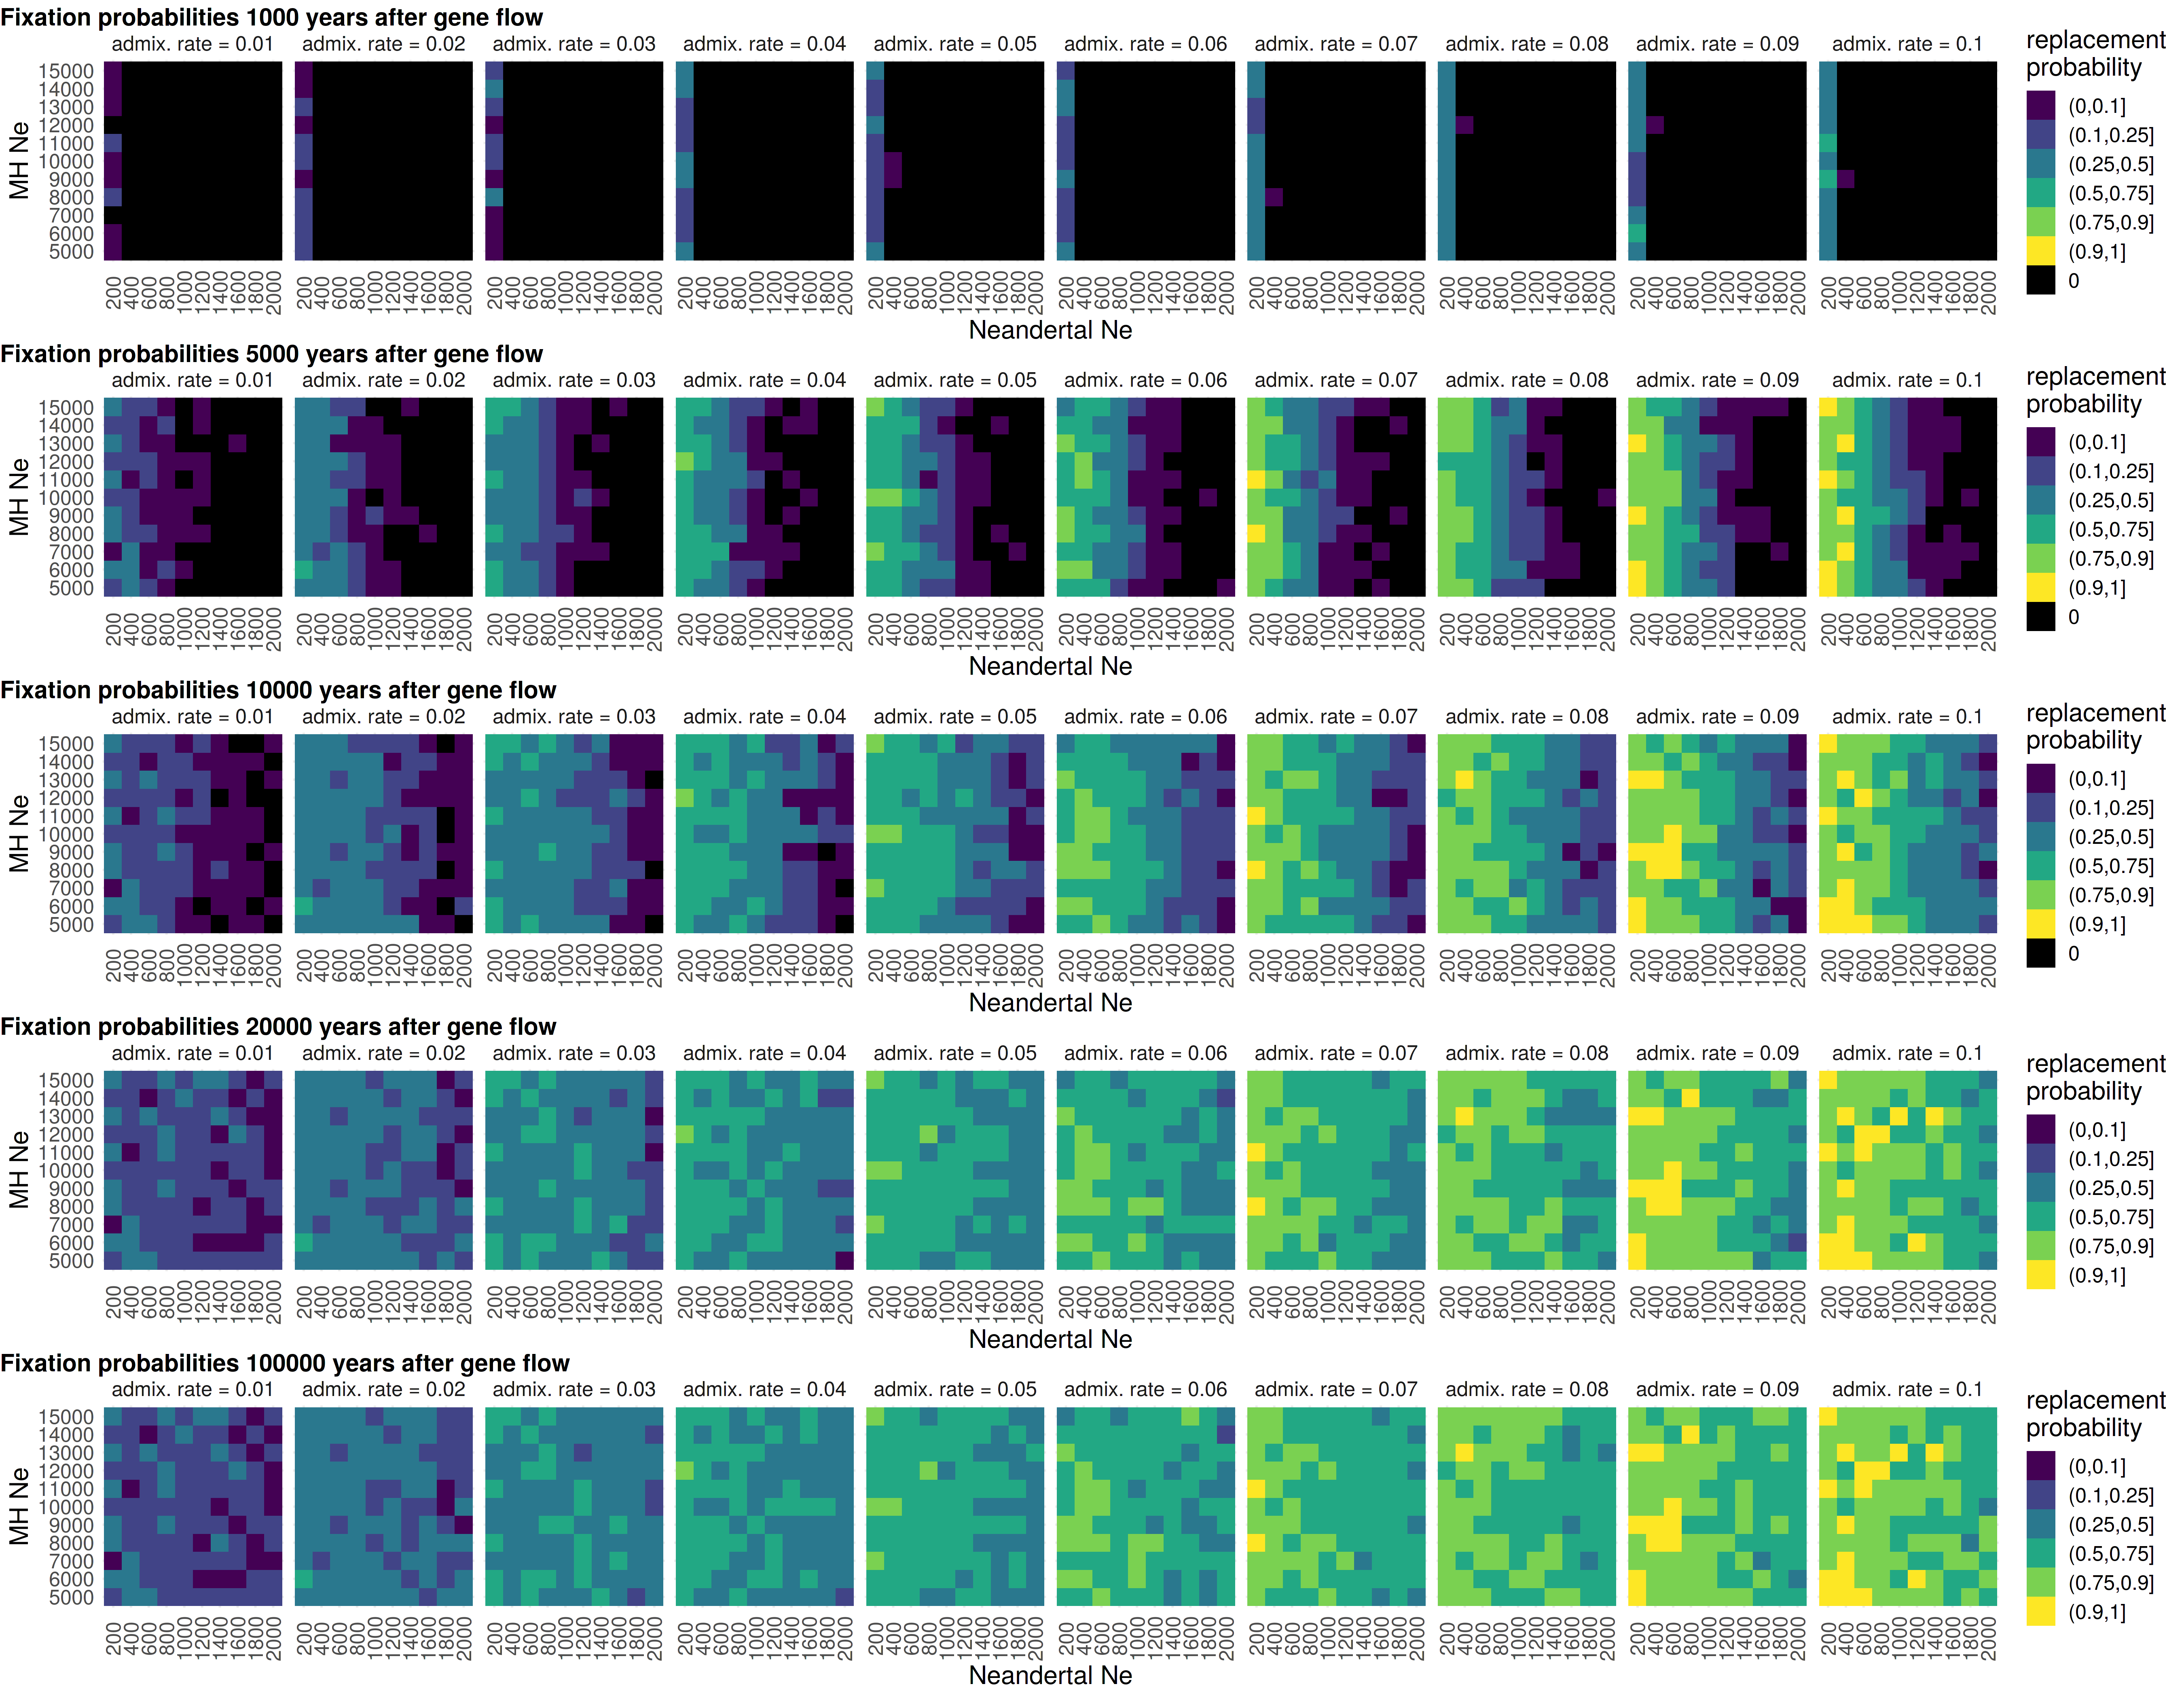

In [58]:
set_dim(18, 14)

plot_grid(
    NULL,
    prob_heatmap(prob_traj_fitness, 1000),
    prob_heatmap(prob_traj_fitness, 5000),
    prob_heatmap(prob_traj_fitness, 10000),
    prob_heatmap(prob_traj_fitness, 20000),
    prob_heatmap(prob_traj_fitness, 100000),
    labels = c("", sprintf("Fixation probabilities %d years after gene flow",
                     c(1000, 5000, 10000, 20000, 100000))),
    hjust = "left", vjust = 0.5,
    ncol = 1,
    rel_heights = c(0.05, rep(1, 5))
)   